# Grade: /20 pts

# Lab Assignment 06: Regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

%matplotlib inline

pydev debugger: warning: trying to add breakpoint to file that does not exist: c:\assignment6-solution.ipynb (will have no effect)


ModuleNotFoundError: No module named 'matplotlib'

### Question1: Preprocessing (1pt)
Tasks:
* Load the data present in 'footballer_small.csv' using the pandas library and store the loaded data in a dataframe
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0

In [2]:
df = pd.read_csv('footballer_small.csv')


# Drop the aformentioned columns
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'], axis = 'columns')

# In order to get dummies, convert categorical data to categorical type
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])

# Dummies, dropping the first category
model_data = pd.get_dummies(model_data, drop_first=False)

y = model_data.overall
X = model_data.drop('overall', axis = 'columns')

# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = 500, 
                                                random_state = 0)
print('Training set size:',Xtrain.shape)

df.head()
X.head()

Training set size: (2500, 48)


,age,height_cm,weight_kg,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_att_High,work_rate_def_Low,work_rate_def_Medium,work_rate_def_High,preferred_foot_Left,preferred_foot_Right
0,29,186.0,82.0,70,50,56,61,66,74,1,2,3,58,44,65,59,49,56,48,42,58,68,64,74,66,62,59,59,80,73,76,51,70,64,43,52,69,65,63,70,0,1,0,0,1,0,0,1
1,21,194.0,87.0,61,57,53,61,45,54,1,1,2,15,19,15,25,13,16,16,15,19,18,48,42,40,57,33,20,44,39,56,14,25,23,12,26,22,22,15,16,0,1,0,0,1,0,0,1
2,23,175.0,72.0,85,28,55,62,60,68,1,2,2,60,22,54,58,24,59,30,35,57,62,88,83,70,53,75,43,73,79,65,24,58,52,48,55,31,34,60,67,0,1,0,0,0,1,0,1
3,26,185.0,80.0,76,54,67,73,69,78,1,2,3,76,41,60,64,52,75,59,40,73,73,73,78,67,68,63,65,70,87,79,74,67,75,68,68,38,66,66,69,0,1,0,0,1,0,0,1
4,19,182.0,76.0,47,46,51,50,39,47,1,1,2,14,11,13,26,12,14,11,11,22,15,37,41,33,45,43,18,56,28,49,12,18,12,12,25,16,38,12,12,0,1,0,0,1,0,0,1


## Question 2: Building the pipeline that preprocesses the data (2pts)
In order to properly build the regression model, the features need to be standardized so that no feature can dominate others in determining the prediction values due to differences in feature scales. Build the pipeline that preprocesses the feature columns of the training data and create a linear regression model. Plot the data before and after the standardization for the stamina feature. <br>
In this question, there is no need to overwrite the training set's values. Create a new variable to include the standardized data. The original training data is needed for future exercises. <br>
### Question
Make observations about the plot.  
### Answer:
After standardization, the data is observed to be more centered and most data points are around 0 representing the mean and concentrated within one std from the mean. <br>

[Text(0, 0.5, 'frequency'),
 Text(0.5, 0, 'stamina'),
 Text(0.5, 1.0, 'After Standardization')]

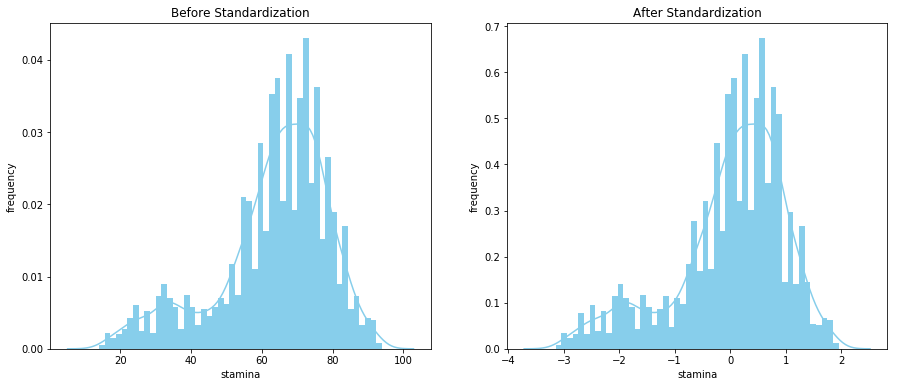

In [3]:
model_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', sk.linear_model.LinearRegression())
])

standardizer_step = model_pipeline.named_steps['standardize']
transformed_X = standardizer_step.fit_transform(Xtrain)
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
ax = sns.distplot(Xtrain.stamina,
                 bins=50,
                 kde=True,
                 color='skyblue',
                 hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='stamina', ylabel='frequency', title="Before Standardization")
plt.subplot(1, 2, 2)
ax = sns.distplot(transformed_X[:, Xtrain.columns.get_loc("stamina")],
                 bins=50,
                 kde=True,
                 color='skyblue',
                 hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='stamina', ylabel='frequency', title="After Standardization")

In [4]:
Xtrain.head()

,age,height_cm,weight_kg,pac,sho,pas,dri,def,phy,international_reputation,skill_moves,weak_foot,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,work_rate_att_Low,work_rate_att_Medium,work_rate_att_High,work_rate_def_Low,work_rate_def_Medium,work_rate_def_High,preferred_foot_Left,preferred_foot_Right
2858,20,178.0,69.0,61,38,52,54,62,71,1,2,2,46,29,61,61,31,53,35,33,48,51,63,59,56,62,66,59,81,77,70,34,64,62,47,52,41,59,62,62,0,1,0,0,1,0,0,1
723,21,182.0,77.0,80,66,64,76,49,64,1,4,2,63,64,66,66,55,77,60,54,65,77,83,78,84,67,62,75,69,73,70,66,34,52,67,65,67,66,43,48,0,1,0,0,1,0,1,0
1953,25,187.0,76.0,73,78,65,77,43,73,1,1,2,12,12,18,34,14,11,9,12,35,23,44,42,43,77,57,25,70,35,55,19,41,13,18,45,27,52,14,15,0,1,0,0,1,0,0,1
1981,21,175.0,77.0,89,72,66,78,33,63,1,3,4,73,74,49,69,65,80,57,55,55,75,90,89,78,67,78,74,55,66,64,71,59,24,72,68,62,68,35,33,0,1,0,0,1,0,0,1
137,19,168.0,59.0,69,53,59,68,44,48,1,2,4,42,50,49,67,51,66,59,52,60,67,77,63,81,54,76,60,57,50,43,54,55,49,47,65,57,60,42,40,0,0,1,0,0,1,0,1


## Question 3: Creating a Complex feature model using 2-nd Polynomial features (2pts)
In this task, the training data consists of the quadratic terms and 2-way interactions of all features except one of standing_tackle, composure, and marking variable. <br> 
Create <b> four </b> different training sets:
* The first training set includes the quadratic terms and 2-way interactions of all the features. 
* The second/third/fourth training sets include all the features, their quadratic terms, and their 2-way interactions except the standing_tackle/composure/marking features. <br>

#### Hint: 
For the 2nd/3rd and 4th training sets, create the training sets without the aforementioned features and then apply polynomial expansion to the resultant sets. 
### Questions:
* How many linear terms are in each of the new feature set?
* How many squared terms are in each of the new feature set?
* How many interaction terms are in each of the new feature set? Give an example of one of the interaction terms. 
### Answer
here are 47/48 columns in our design matrix for the backward feature search purposes.

Setting `degree=2` and `interactions_only=False` computes $x_i\cdot x_j$ for all $i,j=1, \cdots, 47$ and then adds this to our original design matrix. Note that when $i\neq j$, the ordering of the terms does not matter. This is a total of

* 47/48 linear linear terms

* 48x47/2  (49x48/2) interaction terms (this includes the squared terms, If you are interested in knowing how I computed this, read the wikipedia page for "Triangular Number".)

Totalling 1128 (1176) terms

In [5]:
poly = sk.preprocessing.PolynomialFeatures(2)

Xwithout_standing = Xtrain.drop(['standing_tackle'], axis='columns')
Xwithout_standing = poly.fit_transform(Xwithout_standing)
Xwithout_composure = Xtrain.drop(['composure'], axis='columns')
Xwithout_composure = poly.fit_transform(Xwithout_composure)
Xwithout_marking= Xtrain.drop(['marking'], axis='columns')
Xwithout_marking = poly.fit_transform(Xwithout_marking)
X_new_train = poly.fit_transform(Xtrain)


## Question 4: Evaluating the backward feature search (3 pts)
In this question, you have to use the pipeline created in question 2 and apply it to each of the training sets created in question 3. Use 10-fold cross validation to report the validation error on the training set using mean squared error as the metric. <br>
Show all the steps of the process and compare and analyze the results using the validation error reported. 

### Answers:
Clearly, the base model that includes all the features is the worst performing model. The best performing model out of the four models is the model that excludes the marking feature and its corresponding quadratic and interacting feature. This means that this feature has contributed to the degradation of the quality of the model. 

In [6]:
cv_score=cross_val_score(model_pipeline, X_new_train, ytrain, cv=10, scoring='neg_mean_squared_error')
print('base model', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_standing, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without standing tackle', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_composure, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without composure', -cv_score.mean())

cv_score=cross_val_score(model_pipeline, Xwithout_marking, ytrain, cv=10, scoring='neg_mean_squared_error')
print('model without marking', -cv_score.mean())

base model 2.9751377430054324
model without standing tackle 2.753797345010626
model without composure 2.806000515704399
model without marking 2.6954176886402035


## Question 5: Applying Ridge Regression (2 pts)
Build a pipeline that performs scaling and fits the ridge regression on the data that includes the polynomial expansion of all the features. The penalization parameter of is set to 0.5. Use the pipeline to report the validation error using mean square error metric. Use 10-fold cross validation. 

In [7]:
pip = Pipeline([
    ('standardize', StandardScaler()),
    ('reg', Ridge(alpha=0.5, fit_intercept=True))
])
cv_scores = cross_val_score(pip,
                           X_new_train,
                           ytrain,
                           cv=10,
                           scoring='neg_mean_squared_error')
meancv=-cv_scores.mean()
print(meancv)

1.7146770020406563


## Question 6: Tune the Ridge coefficient for the 2nd-order model   (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search going from $\lambda = \exp(-8), \cdots, \exp(6)$ in 15 evenly spaced increments on the log scale. Plot the mean squared error as a function of $\log(\lambda)$. 

### Questions: 

What is the best regularization parameter (actual not approximate)? 

Why does the error increase as $\lambda \rightarrow 0?$  Why does the error increase when $\lambda \rightarrow \infty$?  Answer in terms of the bias variance trade off.

### Answer: 

The best lambda can be found using `gscv.best_params_`. 

As $\lambda \rightarrow 0?$, the model is becoming more variable and so RMSE increases.

As $\lambda \rightarrow \infty?$, the model is becoming more biased and so RMSE increases.

Text(0.5, 0, '$\\log(\\lambda)$')

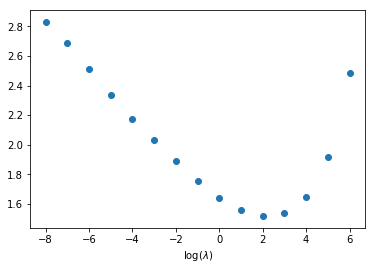

In [8]:
params = {'reg__alpha': np.exp(np.linspace(-8,6,15))}
gscv = GridSearchCV(pip, param_grid=params, cv=10, scoring = 'neg_mean_squared_error', refit=True)
gscv.fit(X_new_train, ytrain)

results = pd.DataFrame(gscv.cv_results_)

plt.scatter( np.linspace(-8, 6,15), -results.mean_test_score)
plt.xlabel(r'$\log(\lambda)$')

### Question 7: Test error  (2pt)
Now test how the ridge model, fitted to the whole training set, on how it performs on the test data set. 


Report the following:

* The mean squared error on the test data - along with the 95% confidencen interval, determined with the central limit theorem. 
* The proportion of the variance explained by your model - along wth a 95% confidence interval.

In [12]:
X_new_test = poly.fit_transform(Xtest)
ypred = gscv.predict(X_new_test)
sqerr = (ytest-ypred)**2 
test_error = sqerr.mean() 
test_ci = test_error + 1.96 * np.std(sqerr) / np.sqrt(len(sqerr)) * np.array([-1, 1])

print("Mean test error: ",test_error)
print("95% CI: ",test_ci)

ss = (ytest-ytest.mean())**2 
print("Proportion variance predicted: ",1-test_error/ss.mean())
print("95% CI: ",[1-test_ci[1]/ss.mean(), 1-test_ci[0]/ss.mean()])

Mean test error:  1.7057441746268356
95% CI:  [1.38183746 2.02965089]
Proportion variance predicted:  0.9669042125842219
95% CI:  [0.9606195962567139, 0.9731888289117299]


## Question 8: Analyzing Ridge Coefficients (3 pts)
In this question, you are first required to extract all the coefficients of the standing tackle, composure and marking features from the best model of question 7. After that, calculate the mean of the coefficients of the aforementioned features and analyze the results. Based on these observations, draw conclusions about the results in question 4. 
### Answers: 
The average coefficients show that out of the marking, standing tackle, and composure features, marking has the least average coefficients followed by composure and standing tackle. The average coefficients show the weight of each of the features in contributing to the prediction. Accordingly, and based on the results, the least important feature for predicting a player's overall is the marking followed by composure and lastly the standing tackle. <br>
According to these observations, a correlation is observed between the coefficient results and the results of the backward feature selection in question 4. 
The best performing model does not include the marking feature in its feature set which correlates to the lower coefficients of this feature after the ridge regression optimization. The same applies to the other two features. This shows that ridge regression successfully lowered the effect of the marking feature which when excluded contributed to producing the best performing model. 

In [10]:
all_features = poly.get_feature_names(Xtrain.columns)
all_coefs = np.array(gscv.best_estimator_.named_steps['reg'].coef_)
all_features = list(all_features)
indices_composure = [i for i, x in enumerate(all_features) if "composure" in x]
indices_std_tackle = [i for i, x in enumerate(all_features) if "standing_tackle" in x]
indices_marking = [i for i, x in enumerate(all_features) if "marking" in x]
coefs_composure = all_coefs[indices_composure]
coefs_std_tackle = all_coefs[indices_std_tackle]
coefs_marking = all_coefs[indices_marking]
print('composure',coefs_composure.mean())
print('standing tackle',coefs_std_tackle.mean())
print('marking',coefs_marking.mean())

composure 0.017963840171817867
standing tackle 0.023687032105555502
marking 0.014336846518152455


## Question 9: Lasso Regression (2pts)
Let us assume that you are building a linear regression model using only three features: standing tackle, marking, and composure to predict a player's overall rating. Based on the results of question 8, what do you think will be the features' coefficients while applying the lasso regression optimization? Answer in no more than 5 sentences. 
### Answer
In the grand scheme of things, both lasso and ridge regression shrink the less important features' coefficients to enhance the performance of the linear regression model. The key difference between the two techniques is that lasso regression intrinsically applies feature selection by shrinking feature coefficients to zero which removes some features. The results show that marking feature is the less important feature out of the ones considered, followed by composure feature and lastly the standing tackle feature. With the increase of the $\lambda$ parameter, the coefficient of the marking feature shrinks to 0, rendering it ineffective in the prediction of the player's overall, then the coefficient of the composure feature shrinks to 0, which leaves the model with a single feature to predict the overall rating. 